In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from TransferLearningModel import TransferLearningModel
from utils import TensorFolderDatasetFinal, TransformDatasetFinal, TensorFolderDatasetFinalFlat, TransformDatasetFinalFlat, TensorFolderDataset, TransformDataset, DicomFineDataset3D

In [ ]:
# Definition of the Data Folder and the initially set variables 
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
scenario = 1
data_augmentation = True
classes = ["nodule", "non-nodule"]
classes_fine = ["A", "B", "E", "G"]
classes_dict = {value: index for index, value in enumerate(classes_fine)}

In [ ]:
# Load the best performing coarse classifier: 3D CNN
checkpoint = torch.load("./weights/final/augmented_3dcnn.pt", weights_only=False)
model = TransferLearningModel(classes, "3dcnn", data_augmentation=data_augmentation, fine=False, scenario=scenario)
model.train_transforms, model.test_transforms = model.get_transforms()
model.model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Load the test set and apply the transformations of the coarse classifier
test_dataset_base = TensorFolderDatasetFinal("./data/final/Merged_3D")
test_dataset = TransformDatasetFinal(test_dataset_base, transform=model.test_transforms)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:655: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Evaluation Accuracy on unseen data: 94.20289855072464


<Figure size 1000x800 with 0 Axes>

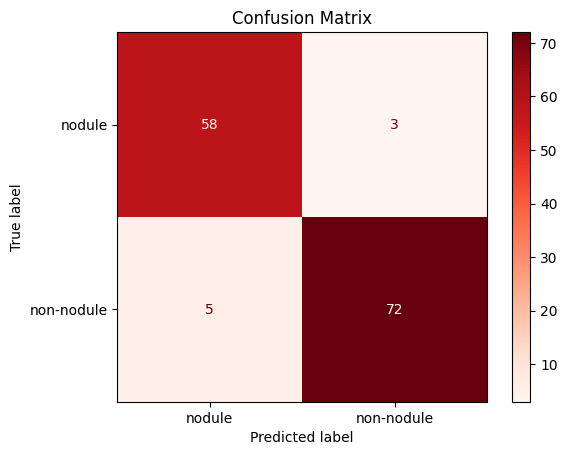

In [ ]:
# Evaluate the model on the test set and display the confusion matrix for the predictions
# Here the save folder is set so the true positive predictions will be saved in this folder for the fine classification of the hierarchical approach
loss = checkpoint["loss"]
model.evaluate_final(test_loader, save_dir="./data/final/Predicted_Nodules")
# model.evaluate_final(test_loader)

In [ ]:
# load a saved volume to see the different keys --> image (tensor of the image), label (coarse label of the volume), slice_paths (list of filepaths for all 2D slices of the volume),
# label_fine (fine label for the 3D volume)
predicted_volume = torch.load("./data/final/Predicted_Nodules/tensor_106_label_coarse_0_label_fine_1.pt")
predicted_volume.keys()

C:\Users\Dominik Hahn\AppData\Local\Temp\ipykernel_18236\592043922.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predicted_volume = torch.load("./data/final/Predicted_

dict_keys(['image', 'label', 'slice_paths', 'label_fine'])

In [ ]:
# load the best performing fine classifier: EfficientNet B0
checkpoint_fine = torch.load("./weights/final/efficientnet.pt", weights_only=False)
model_fine = TransferLearningModel(classes_fine, "efficientnet", data_augmentation=False, fine=True)
model_fine.train_transforms, model_fine.test_transforms = model_fine.get_transforms()
model_fine.model.load_state_dict(checkpoint_fine['model_state_dict'])

<All keys matched successfully>

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:685: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_pt_file = torch.load(os.path.join(tensor_fo

Evaluation Accuracy on unseen data: 100.0


<Figure size 1000x800 with 0 Axes>

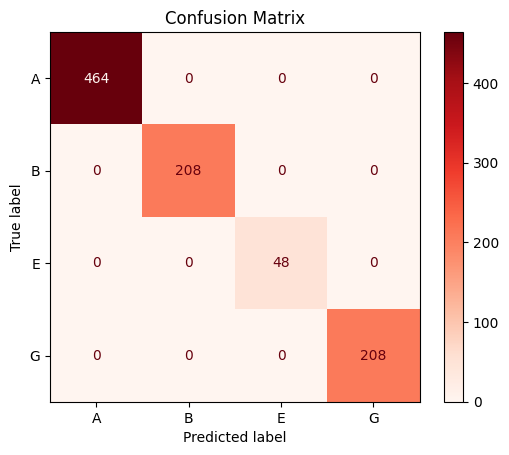

In [ ]:
# load the true positive predictions of the coarse classifier as test set for the fine classifier
test_dataset_fine_base = TensorFolderDatasetFinalFlat(tensor_folder_path="./data/final/Predicted_Nodules", dicom_folder_path=BASE_DIR)
test_dataset_fine = TransformDatasetFinalFlat(test_dataset_fine_base, transform=model_fine.test_transforms)
test_loader_fine = DataLoader(test_dataset_fine, batch_size=32, shuffle=False)
# Evaluation of the test set of the fine classifier and visualization of the confusion matrix
model_fine.evaluate(test_loader_fine)